In [2]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import time

In [3]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
EPOCHS = 10
noise_dim = 100
num_examples_to_generate = 16

In [4]:
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [5]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [7]:
def make_generator_model():
    model = tf.keras.Sequential()

    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [8]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [9]:
generator = make_generator_model()
discriminator = make_discriminator_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [11]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [12]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [13]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [14]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

In [15]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [16]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [17]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.close()

In [18]:
gen_loss_list = []
disc_loss_list = []

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
        gen_loss_list.append(gen_loss)
        disc_loss_list.append(disc_loss)

        if (epoch + 1) % 10 == 0:
            generate_and_save_images(generator, epoch + 1, seed)

        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print('Time for epoch {} is {} sec, gen_loss: {}, disc_loss: {}'.format(
            epoch + 1, time.time()-start, gen_loss, disc_loss))

    generate_and_save_images(generator, epochs, seed)

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

train(train_dataset, EPOCHS)

Time for epoch 1 is 655.7106096744537 sec, gen_loss: 0.6957998871803284, disc_loss: 1.4480127096176147
Time for epoch 2 is 658.0873861312866 sec, gen_loss: 0.9447585344314575, disc_loss: 1.0862088203430176
Time for epoch 3 is 650.9459366798401 sec, gen_loss: 0.8421900272369385, disc_loss: 1.1532948017120361
Time for epoch 4 is 652.294939994812 sec, gen_loss: 0.8575119972229004, disc_loss: 1.2403995990753174
Time for epoch 5 is 649.4954764842987 sec, gen_loss: 0.873160183429718, disc_loss: 1.2940623760223389
Time for epoch 6 is 647.2752997875214 sec, gen_loss: 0.7952240705490112, disc_loss: 1.2134485244750977
Time for epoch 7 is 652.0494384765625 sec, gen_loss: 0.995049238204956, disc_loss: 1.145973801612854
Time for epoch 8 is 648.4282801151276 sec, gen_loss: 1.0305156707763672, disc_loss: 1.0044095516204834
Time for epoch 9 is 646.6500680446625 sec, gen_loss: 0.9087271690368652, disc_loss: 1.220918893814087
Time for epoch 10 is 646.6262724399567 sec, gen_loss: 1.0418264865875244, disc

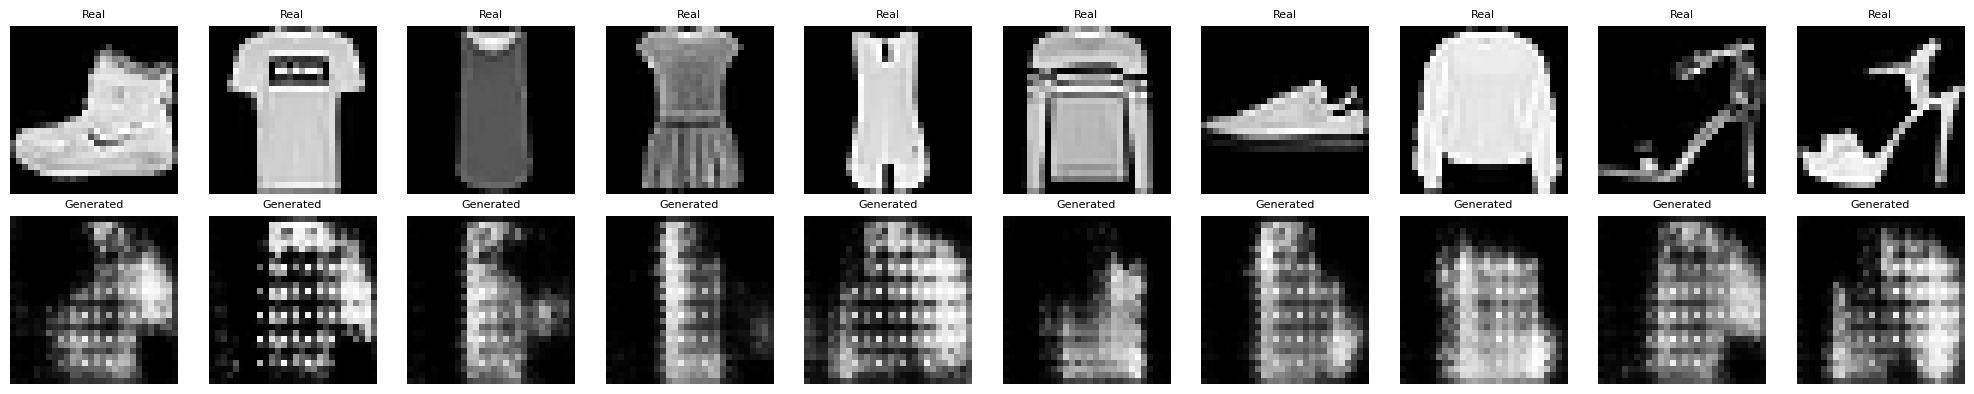

In [19]:
import matplotlib.pyplot as plt
import numpy as np

real_images = train_images[:10]

noise = tf.random.normal([10, noise_dim])
generated_images = generator(noise, training=False)

real_images = (real_images * 127.5 + 127.5) / 255.0
generated_images = (generated_images * 127.5 + 127.5) / 255.0

plt.figure(figsize=(20, 4))

for i in range(10):
    ax = plt.subplot(2, 10, i+1)
    plt.imshow(real_images[i].reshape(28, 28), cmap='gray')
    plt.title("Real", fontsize=8)
    plt.axis('off')

for i in range(10):
    ax = plt.subplot(2, 10, i+11)
    plt.imshow(generated_images[i].numpy().reshape(28, 28), cmap='gray')
    plt.title("Generated", fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.savefig('real_vs_generated.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
from skimage.metrics import structural_similarity as ssim

def calculate_ssim(real_images, generated_images):
    scores = []
    for i in range(10):
        real = real_images[i].squeeze()
        gen = generated_images[i].numpy().squeeze()
        scores.append(ssim(real, gen, data_range=2.0))
    return np.mean(scores)

ssim_score = calculate_ssim(real_images, generated_images)
print(f"SSIM Score: {ssim_score:.4f}")

SSIM Score: 0.1510


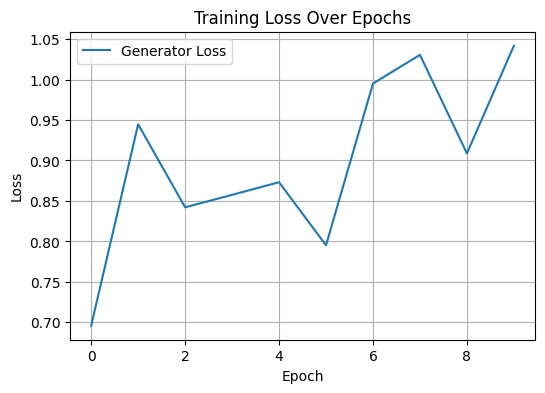

In [21]:

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(gen_loss_list, label='Generator Loss')
# plt.plot(disc_loss_list, label='Discriminator Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


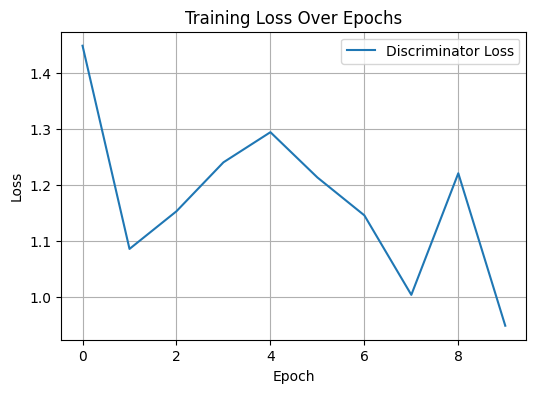

In [22]:


plt.figure(figsize=(6, 4))
# plt.plot(gen_loss_list, label='Generator Loss')
plt.plot(disc_loss_list, label='Discriminator Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()